In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import datetime as dt
import seaborn as sns

In [314]:
transactions = pd.read_csv("Data/transactions.csv")
transactions.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [315]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['new_years_day'] = np.where((transactions['date'].dt.month == 1) & (transactions['date'].dt.day == 1), 1,0)
transactions['day_cat'] = transactions['date'].dt.day_name()
transactions["trans_lag"] = transactions.groupby('store_nbr')['transactions'].shift(1)
transactions["trans_lag_2"] = transactions.groupby('store_nbr')['transactions'].shift(2)
transactions = transactions.dropna(subset=['trans_lag'])
transactions = transactions.dropna(subset=['trans_lag_2'])

In [316]:
transactions["store_nbr"] = transactions["store_nbr"].astype("category")

In [317]:
stores = pd.read_csv("Data/stores.csv")
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [318]:
df = pd.merge(transactions, stores, on = 'store_nbr')
df.head()

date  store_nbr  transactions  new_years_day   day_cat  trans_lag  \
0 2013-01-03         25           887              0  Thursday     1038.0   
1 2013-01-04          1          1863              0    Friday     1833.0   
2 2013-01-04          2          2066              0    Friday     2033.0   
3 2013-01-04          3          3188              0    Friday     3026.0   
4 2013-01-04          4          1596              0    Friday     1551.0   

   trans_lag_2     city        state type  cluster  
0        770.0  Salinas  Santa Elena    D        1  
1       2111.0    Quito    Pichincha    D       13  
2       2358.0    Quito    Pichincha    D       13  
3       3487.0    Quito    Pichincha    D        8  
4       1922.0    Quito    Pichincha    D        9

In [348]:
df['day_nbr'] = df['day_cat'] +'_'+ df['store_nbr'].astype(str)
df['cluster'] = df['cluster'].astype('category')
df.head()

date  store_nbr  transactions  new_years_day   day_cat  trans_lag  \
0 2013-01-03         25           887              0  Thursday     1038.0   
1 2013-01-04          1          1863              0    Friday     1833.0   
2 2013-01-04          2          2066              0    Friday     2033.0   
3 2013-01-04          3          3188              0    Friday     3026.0   
4 2013-01-04          4          1596              0    Friday     1551.0   

   trans_lag_2     city        state type cluster             day_state  \
0        770.0  Salinas  Santa Elena    D       1  Thursday_Santa Elena   
1       2111.0    Quito    Pichincha    D      13      Friday_Pichincha   
2       2358.0    Quito    Pichincha    D      13      Friday_Pichincha   
3       3487.0    Quito    Pichincha    D       8      Friday_Pichincha   
4       1922.0    Quito    Pichincha    D       9      Friday_Pichincha   

       day_nbr  
0  Thursday_25  
1     Friday_1  
2     Friday_2  
3     Friday_3  
4     Friday_4

In [367]:
X = df[["store_nbr","trans_lag", "trans_lag_2", 'day_cat', 'city', 'state', 'type', 'cluster', 'day_state', 'day_nbr']]
df_encoded = pd.get_dummies(X,columns=['store_nbr','day_cat', 'city', 'state', 'type',  'cluster', 'day_state', 'day_nbr'], drop_first=True)

# Select numerical columns to standardize
numerical_cols = ['trans_lag', 'trans_lag_2']

# Standardizing the data
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Show the standardized dataframe
# print(df_encoded)

from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction (let's reduce to 2 components for simplicity)
pca = PCA(n_components=6)
X_pca = pca.fit_transform(df_encoded)

# Convert the PCA result into a DataFrame
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6'])

# Show the PCA result
print(df_pca)

           PCA1      PCA2      PCA3      PCA4      PCA5      PCA6
0     -1.176952  0.621633 -0.600461 -0.356626  0.298291 -0.097636
1      0.754852  1.065425 -0.315837  0.079089 -0.406292  0.035750
2      1.059774  1.032465 -0.332057  0.025662 -0.431380  0.047337
3      2.528362  0.481092 -0.291765 -0.333365 -0.351700  0.096319
4      0.428474  1.120470 -0.313228  0.127858 -0.361920  0.006673
...         ...       ...       ...       ...       ...       ...
83375  1.356183 -0.770111  0.021578 -0.664086  0.542849 -0.175818
83376 -0.309747 -1.055962 -0.607392  0.100078 -0.459521  0.168236
83377  0.687286 -0.442985  0.034658 -0.409448  0.368116 -0.019775
83378 -0.992669  0.701693 -0.591603 -0.445015  0.177295  0.076079
83379 -1.374235 -0.155642  0.860158 -0.334490 -0.105186  0.599405

[83380 rows x 6 columns]


In [370]:
y = transactions.loc[:,"transactions"]

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=2, test_size = 20000)

# Iterate over the splits
for train_index, test_index in tscv.split(df_pca):
    X_train, X_test = df_pca.iloc[train_index], df_pca.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

display(X_train.head())
display(X_train.shape)
display(X_test.shape)

PCA1      PCA2      PCA3      PCA4      PCA5      PCA6
0 -1.176952  0.621633 -0.600461 -0.356626  0.298291 -0.097636
1  0.754852  1.065425 -0.315837  0.079089 -0.406292  0.035750
2  1.059774  1.032465 -0.332057  0.025662 -0.431380  0.047337
3  2.528362  0.481092 -0.291765 -0.333365 -0.351700  0.096319
4  0.428474  1.120470 -0.313228  0.127858 -0.361920  0.006673

(63380, 6)

(20000, 6)

In [371]:
# Train the model
model = LinearRegression()
# (X[1:], y[1:]) 
model.fit(X_train, y_train)
# Access the coefficients
coefficients = model.coef_
intercept = model.intercept_

# X_test = data_pipline(test,["family", "city"])
y_pred = pd.Series(model.predict(X_test))
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 120203.09153852602


In [341]:
resid = df.iloc[test_index]
y_pred = y_pred.to_frame(name='y_pred').reset_index(drop = True).set_index(resid.index)
resid = pd.merge(resid, y_pred, left_index=True, right_index=True, how='outer')
resid['residuals'] = resid['transactions'] - resid['y_pred']
resid.head()

date  store_nbr  transactions  new_years_day day_cat  trans_lag  \
63380 2016-07-31         23           879              0  Sunday     1028.0   
63381 2016-07-31         24          1796              0  Sunday     2378.0   
63382 2016-07-31         25           796              0  Sunday     1041.0   
63383 2016-07-31         26           582              0  Sunday      616.0   
63384 2016-07-31         27          1981              0  Sunday     1755.0   

       trans_lag_2       city        state type  cluster           day_state  \
63380       1028.0     Ambato   Tungurahua    D        9   Sunday_Tungurahua   
63381       2310.0  Guayaquil       Guayas    D        1       Sunday_Guayas   
63382        920.0    Salinas  Santa Elena    D        1  Sunday_Santa Elena   
63383        521.0  Guayaquil       Guayas    D       10       Sunday_Guayas   
63384       1585.0      Daule       Guayas    D        1       Sunday_Guayas   

         day_nbr       y_pred   residuals  
63380  Sunday_23   965.512645  -86.512645  
63381  Sunday_24  1825.409152  -29.409152  
63382  Sunday_25   659.040830  136.959170  
63383  Sunday_26   645.172148  -63.172148  
63384  Sunday_27  1853.302869  127.697131

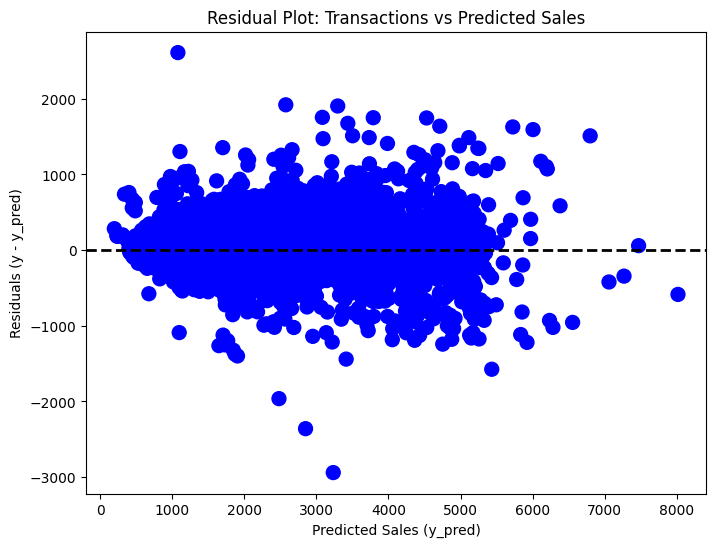

In [342]:
# Plotting
plt.figure(figsize=(8, 6))

# Scatter plot with two colors based on 'new_years_day' (True or False)
plt.scatter(resid['y_pred'], resid['residuals'], 
            c=resid['new_years_day'].map({1: 'green', 0: 'blue'}), s=100)

# Add a horizontal line at 0 (for residuals)
plt.axhline(0, color='black', lw=2, linestyle='--')

# Add labels and title
plt.title('Residual Plot: Transactions vs Predicted Sales')
plt.xlabel('Predicted Sales (y_pred)')
plt.ylabel('Residuals (y - y_pred)')

# Show the plot
plt.show()

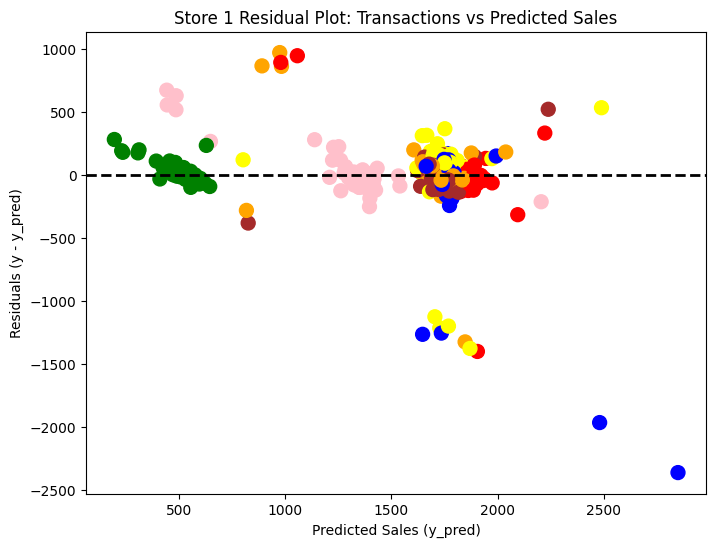

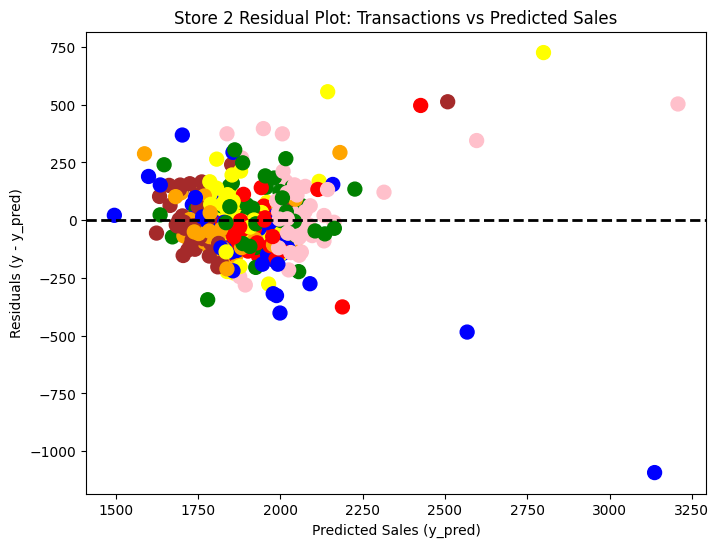

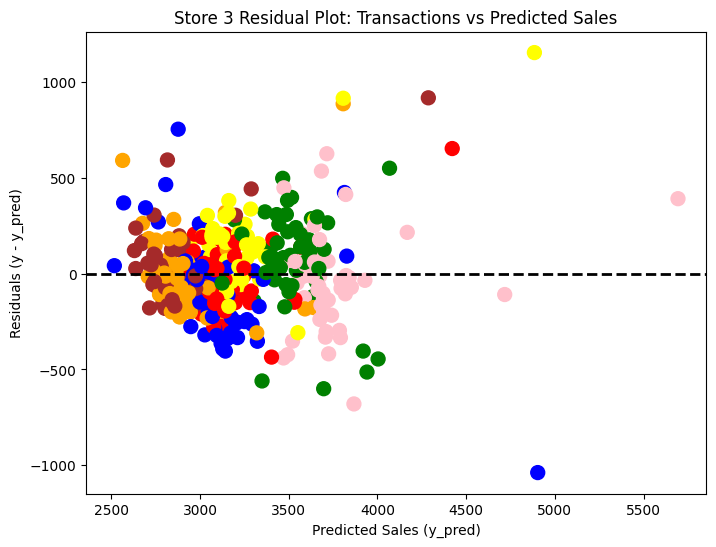

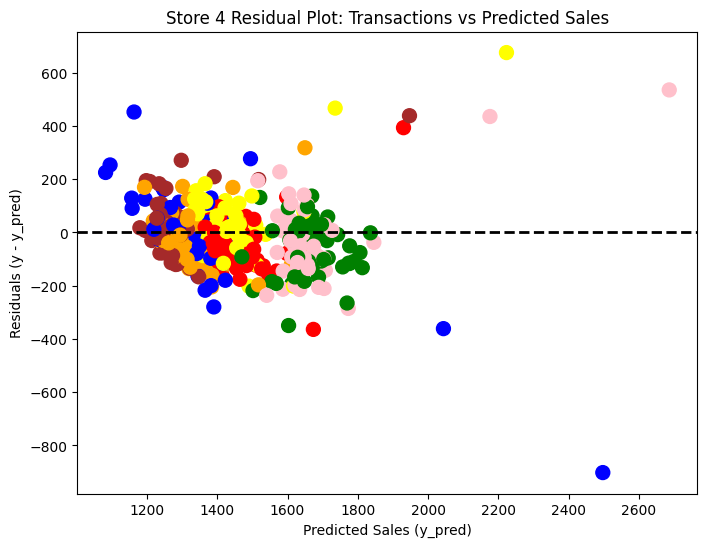

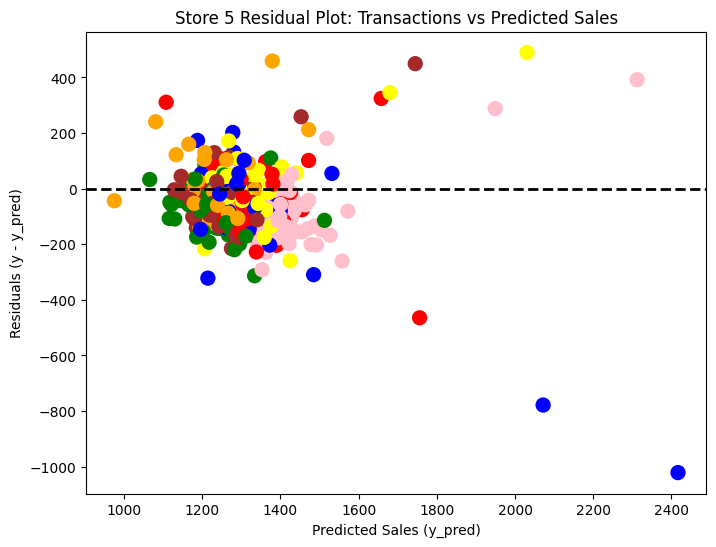

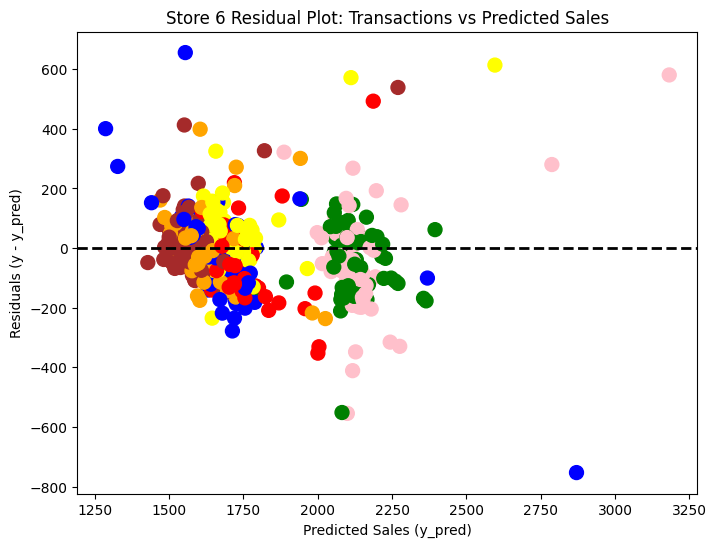

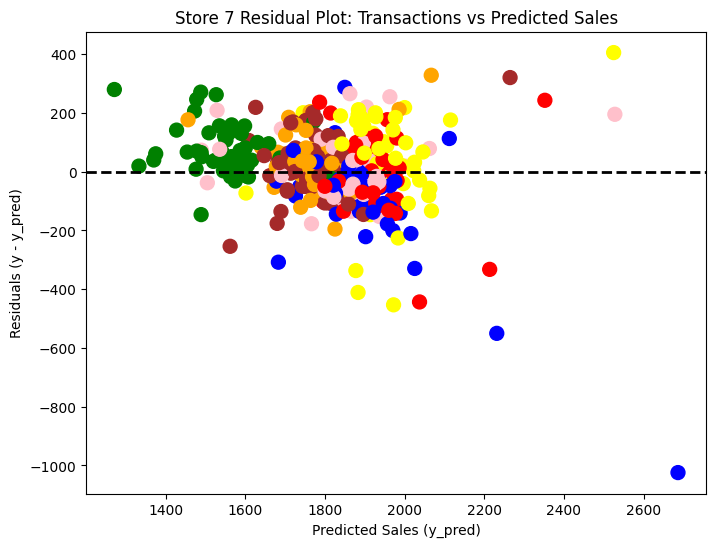

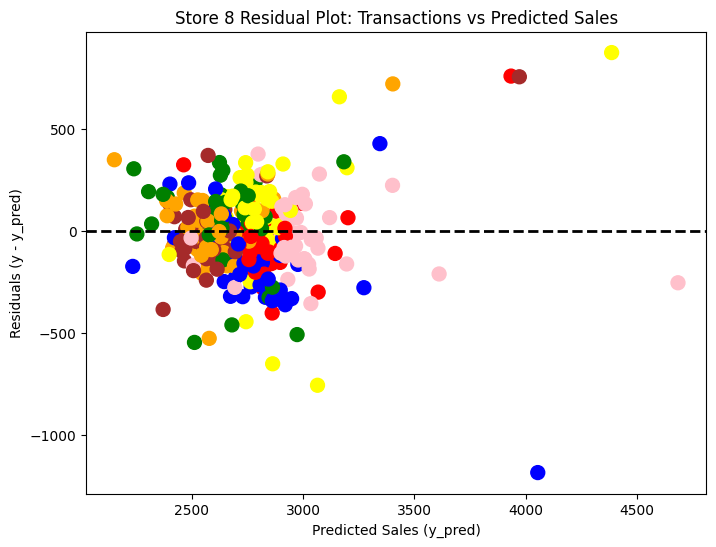

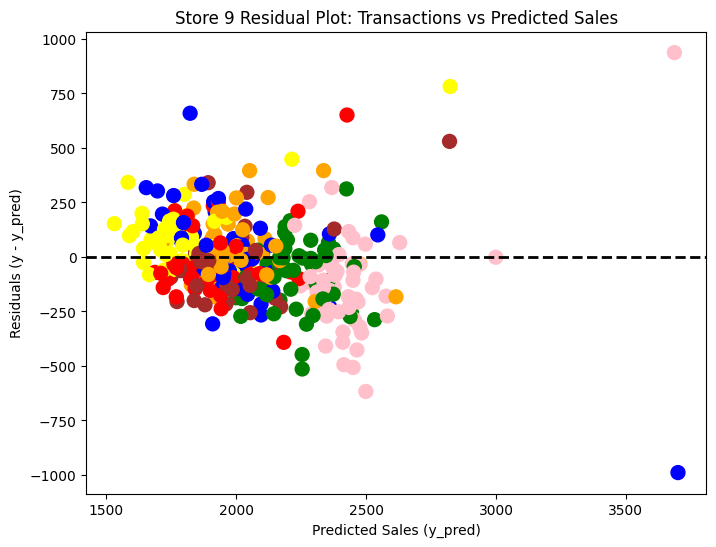

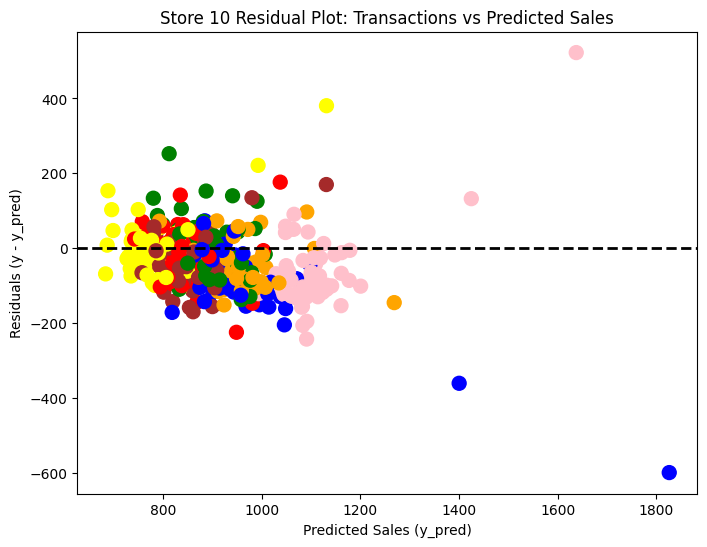

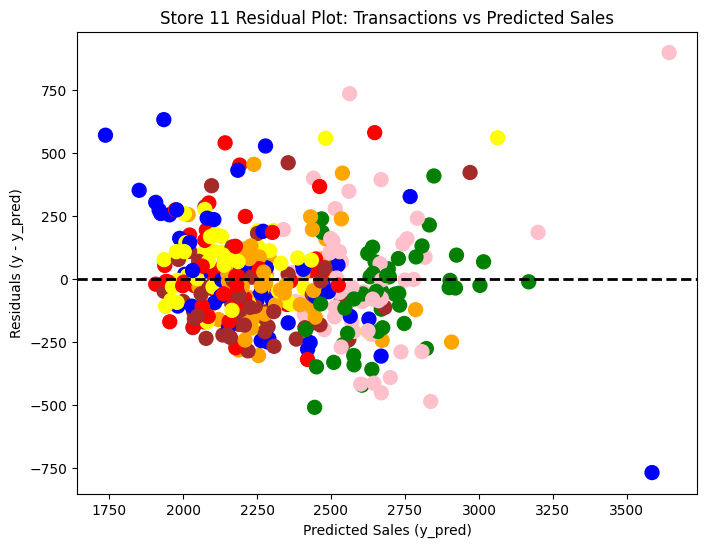

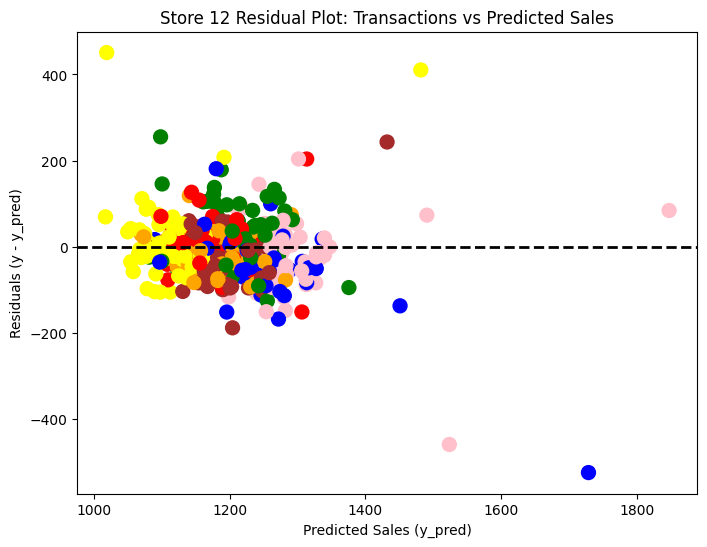

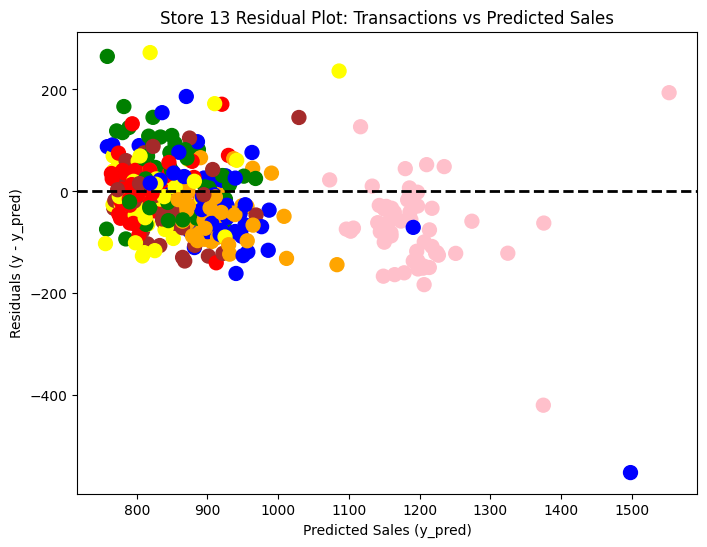

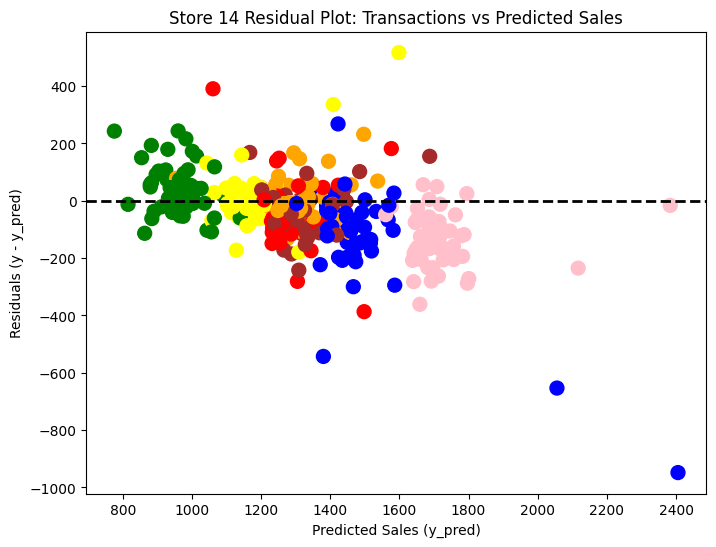

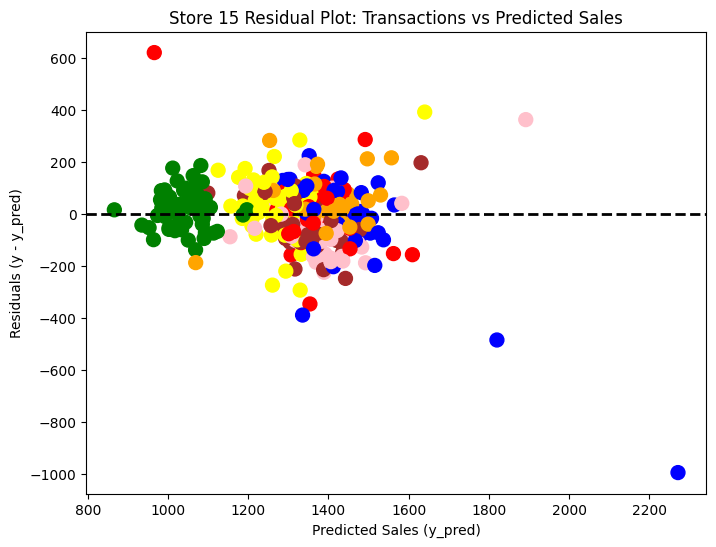

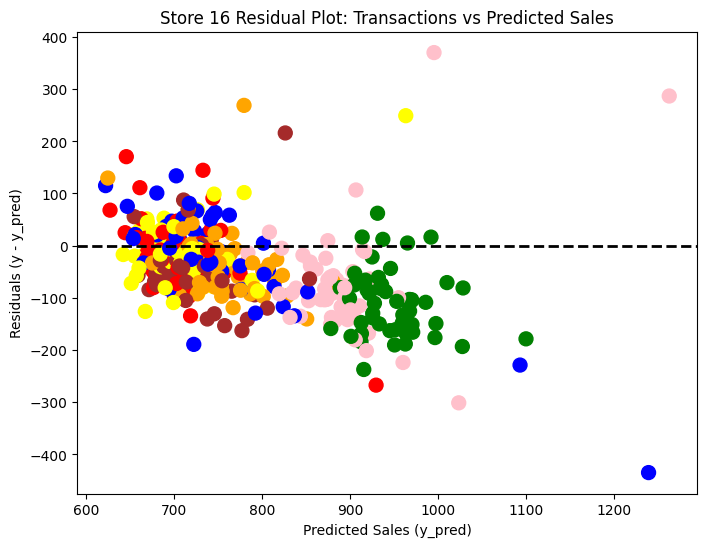

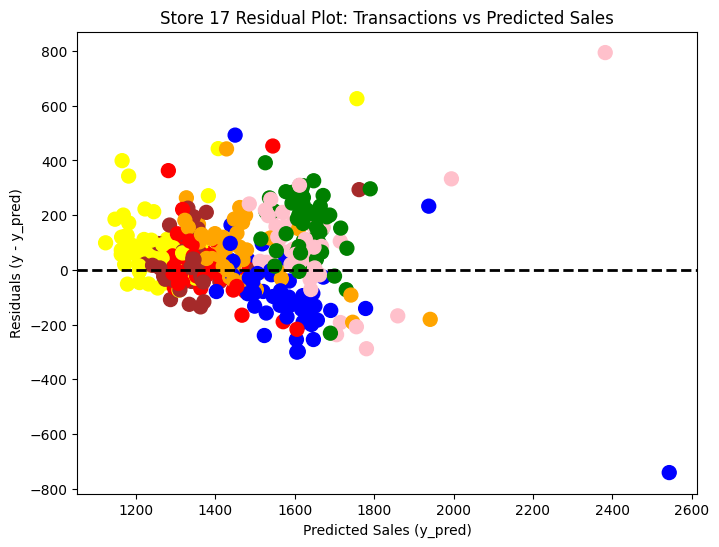

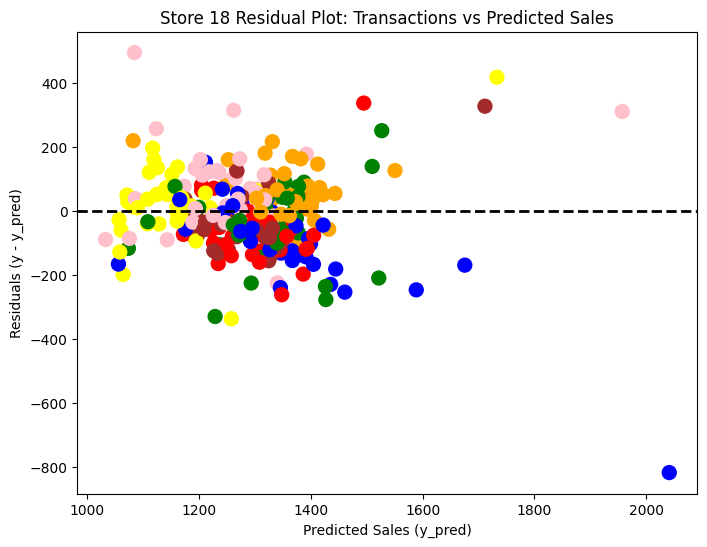

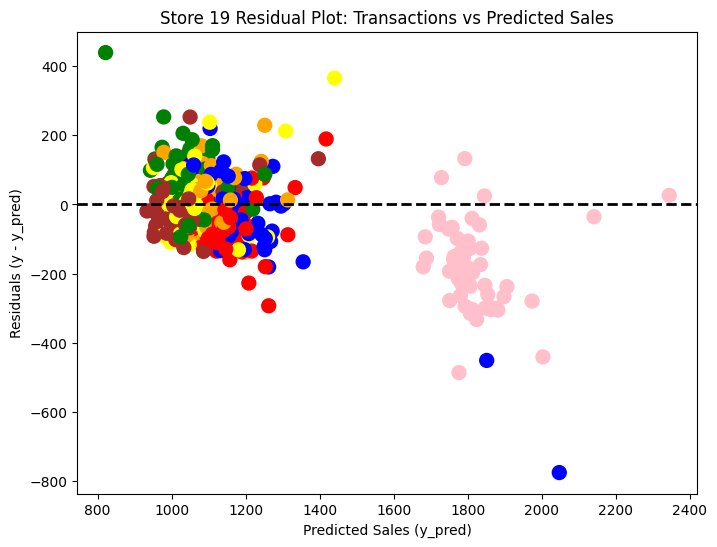

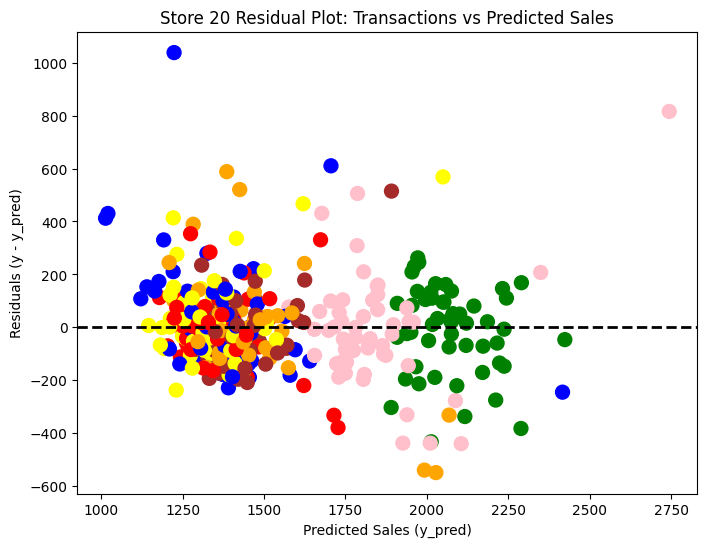

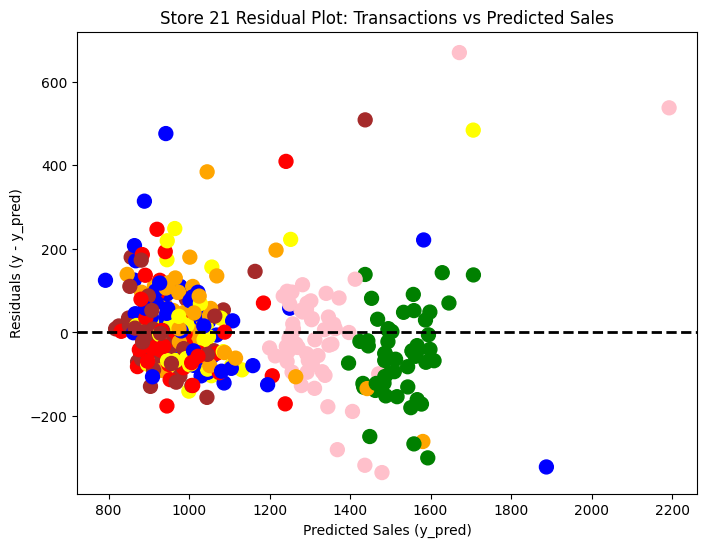

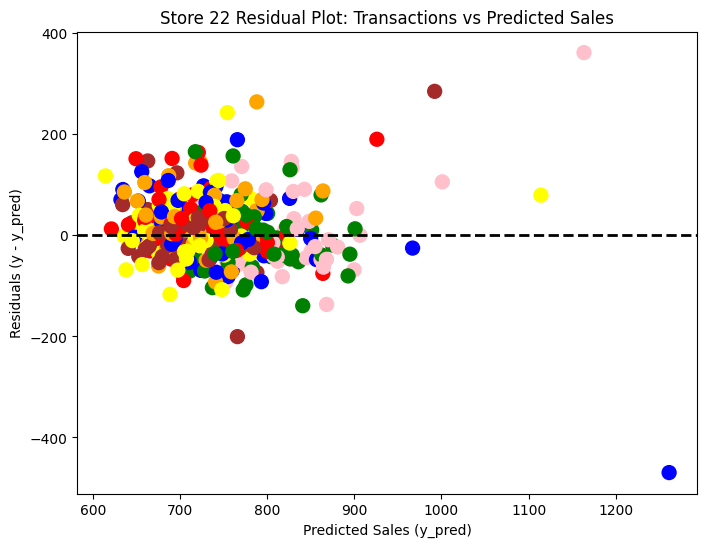

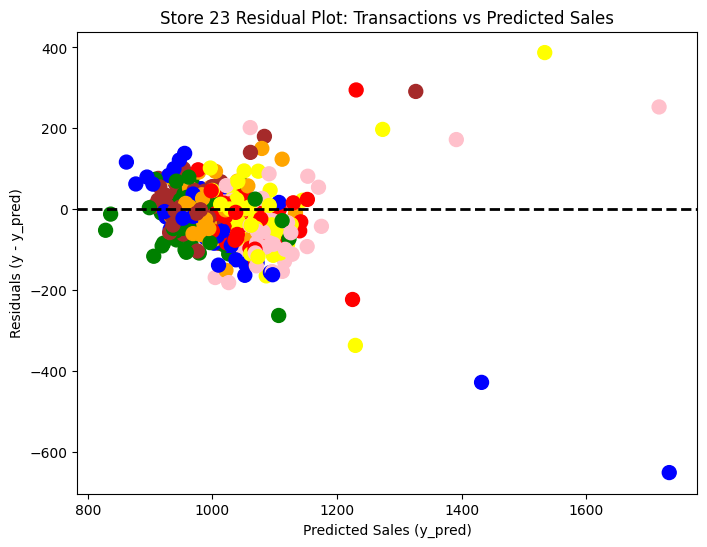

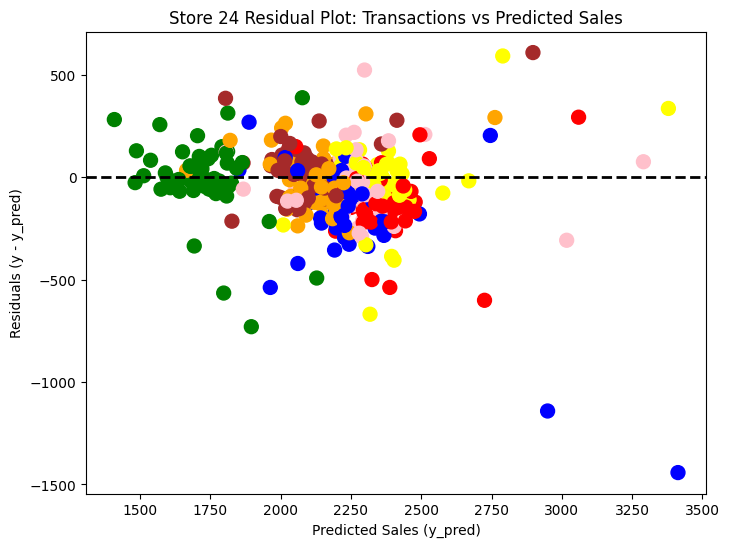

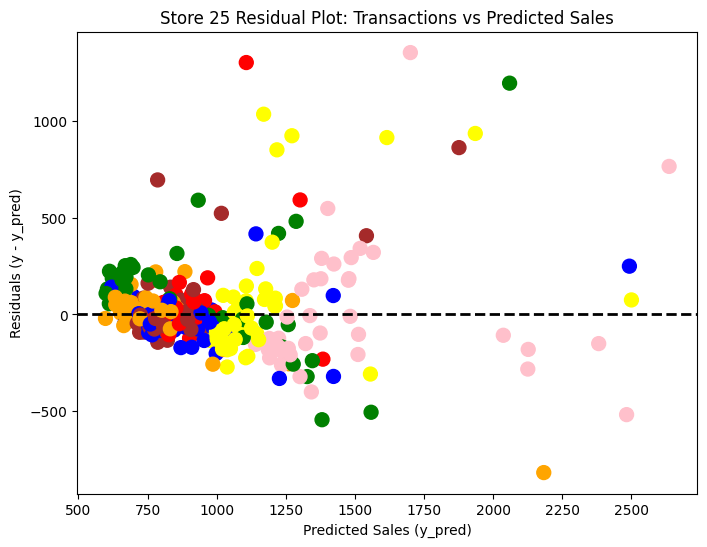

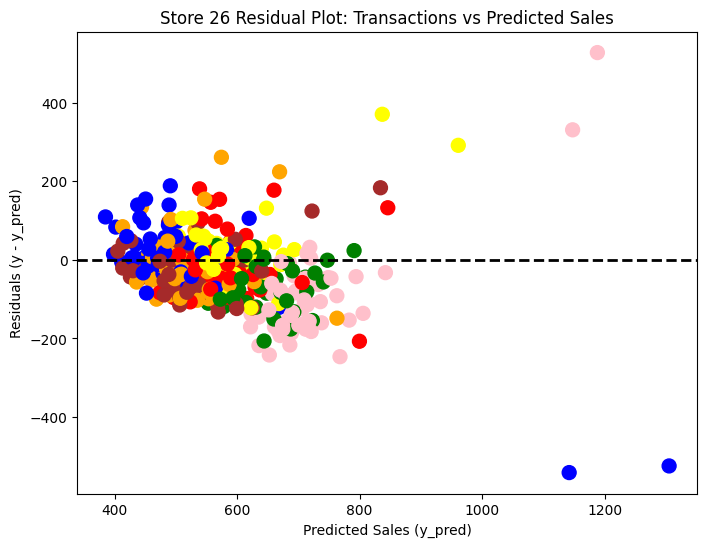

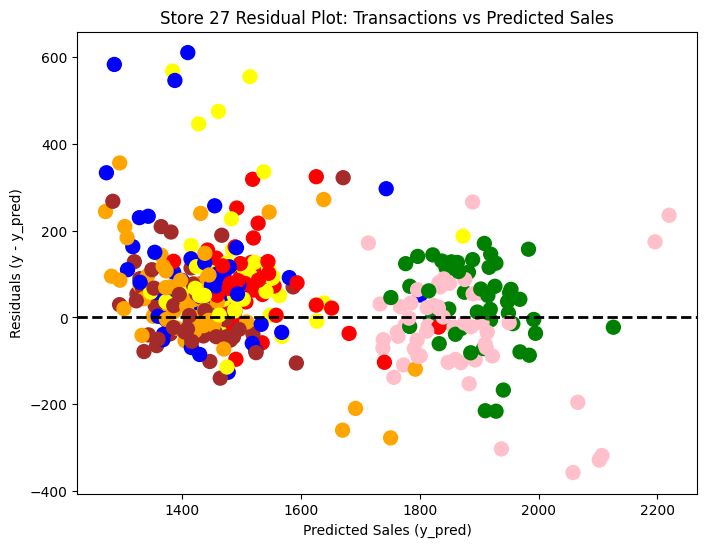

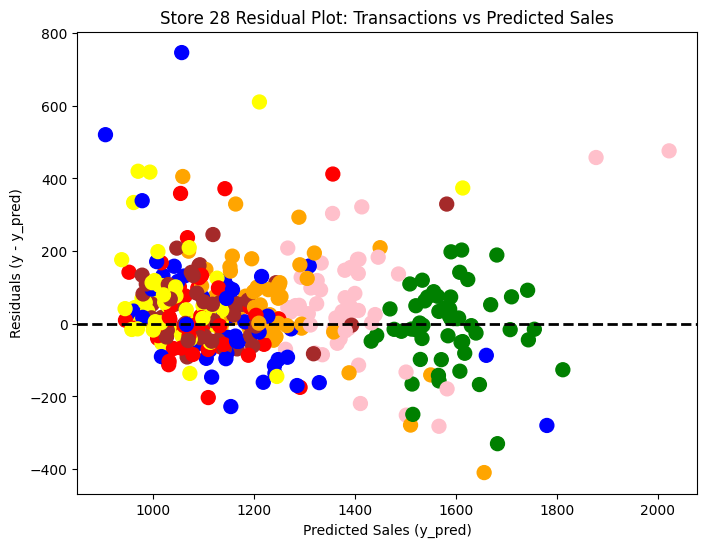

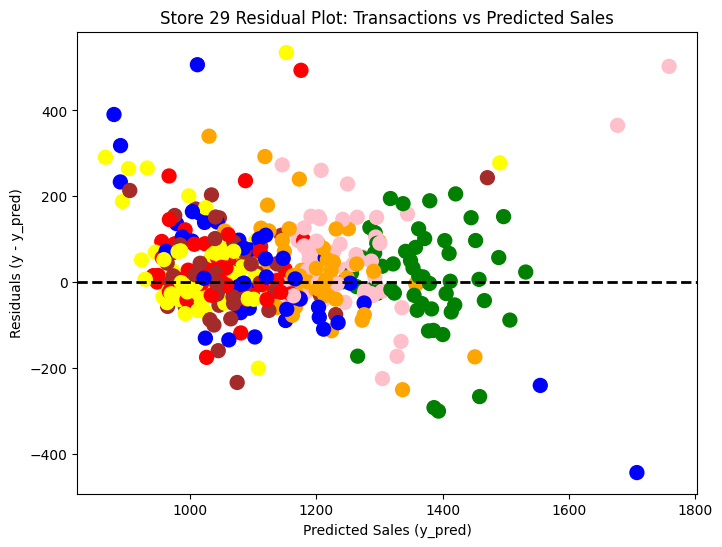

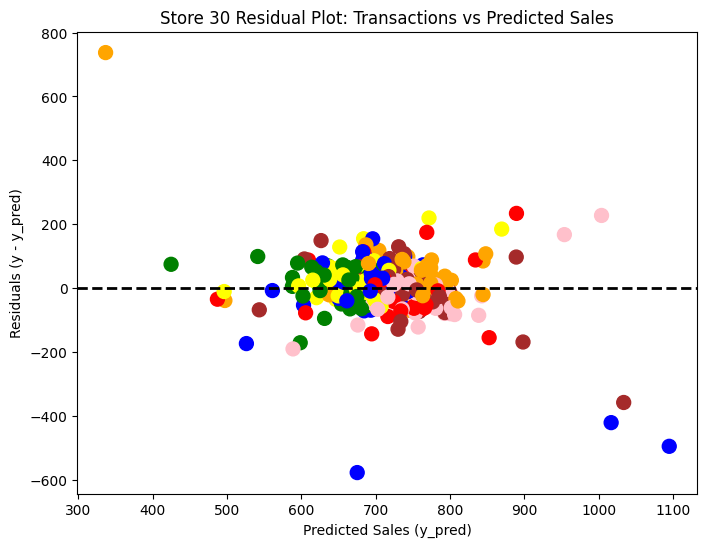

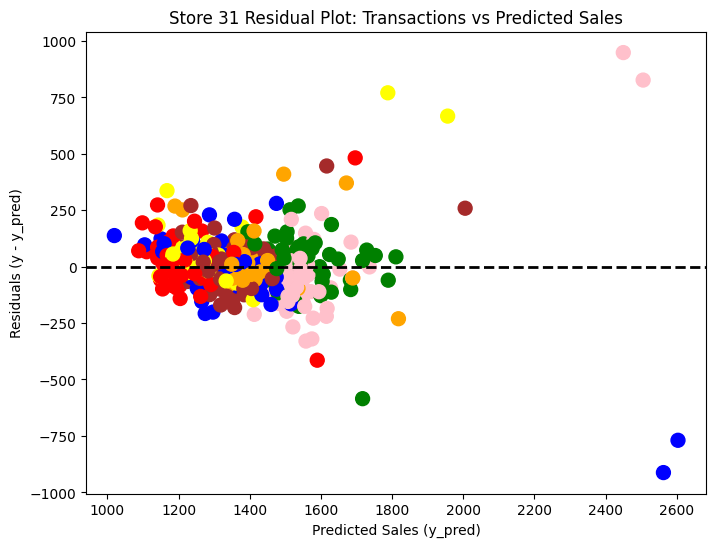

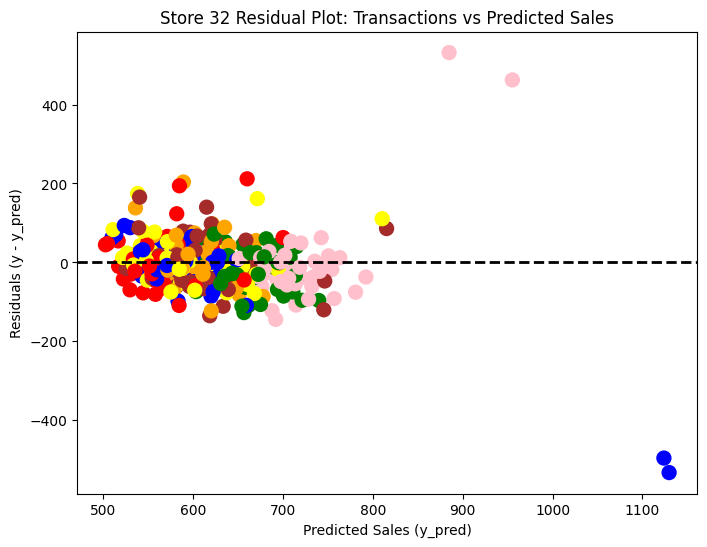

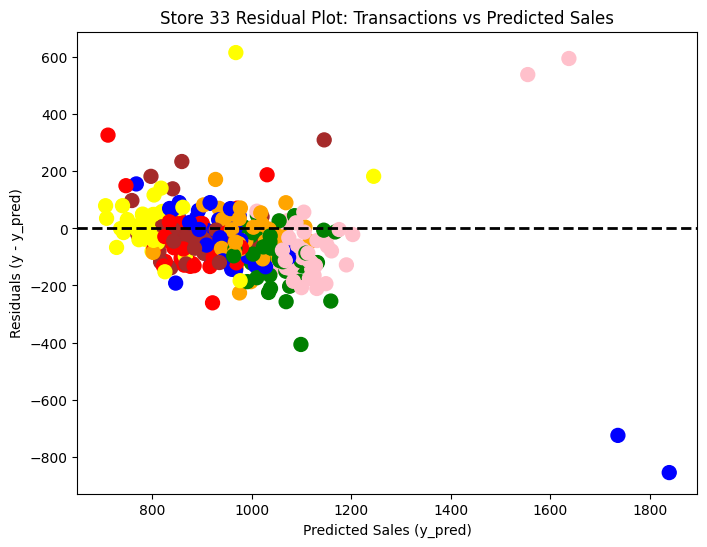

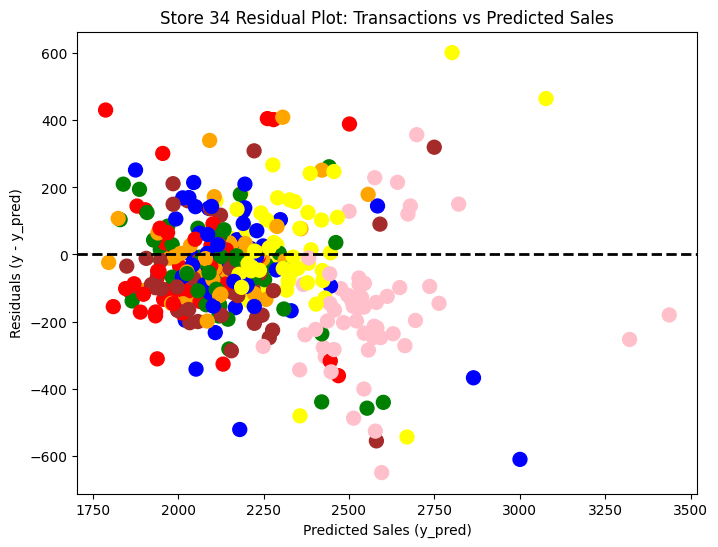

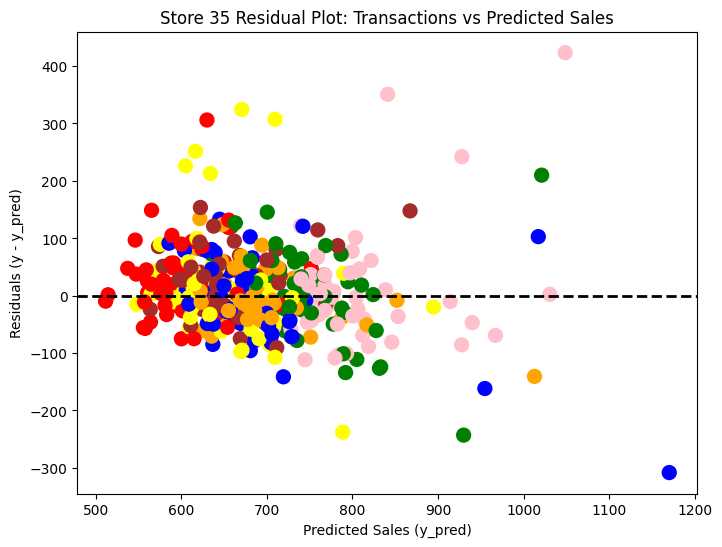

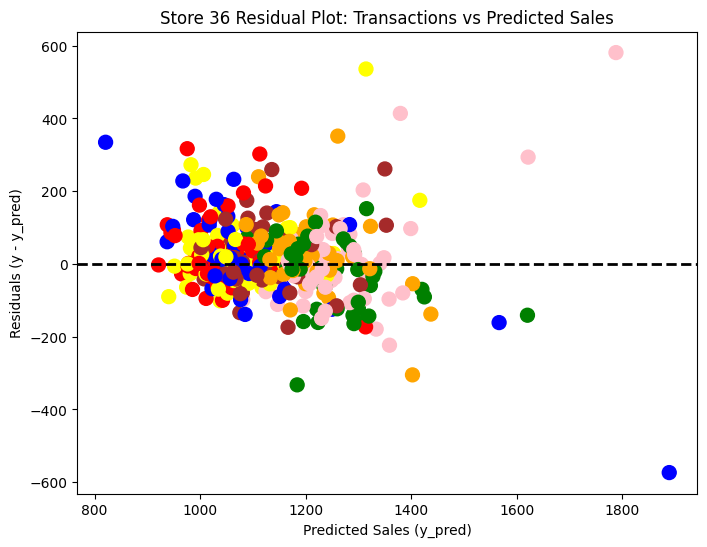

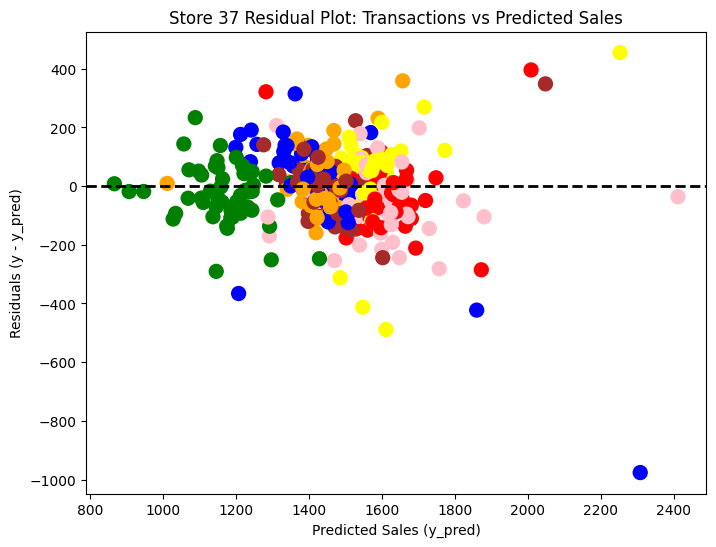

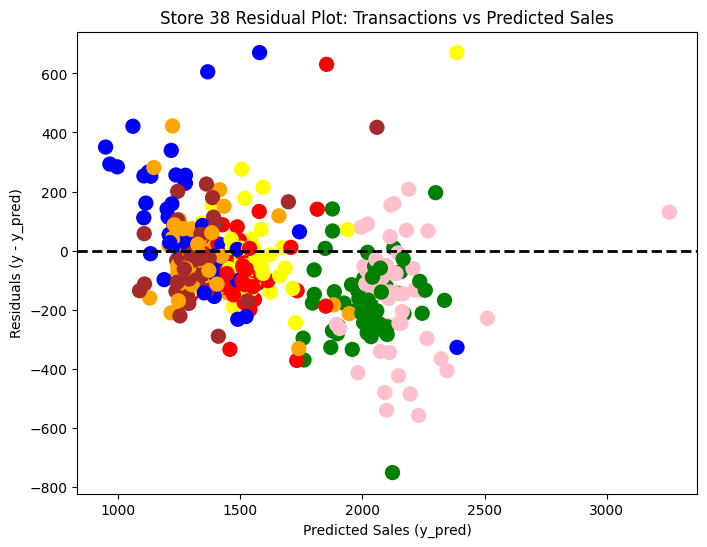

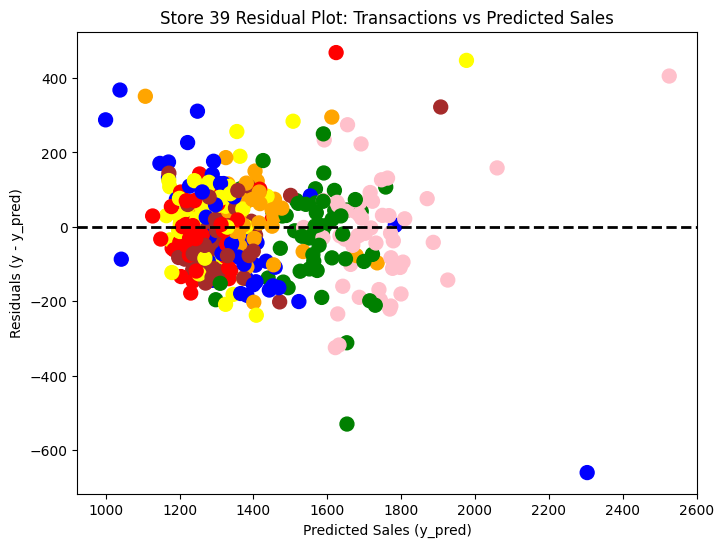

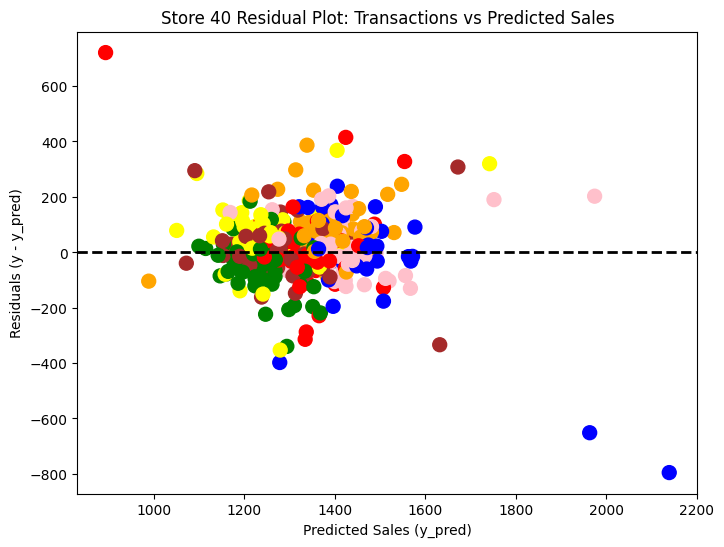

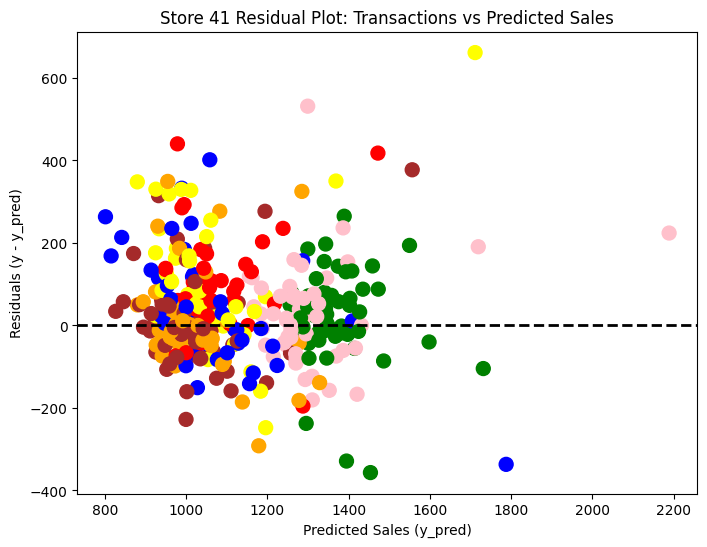

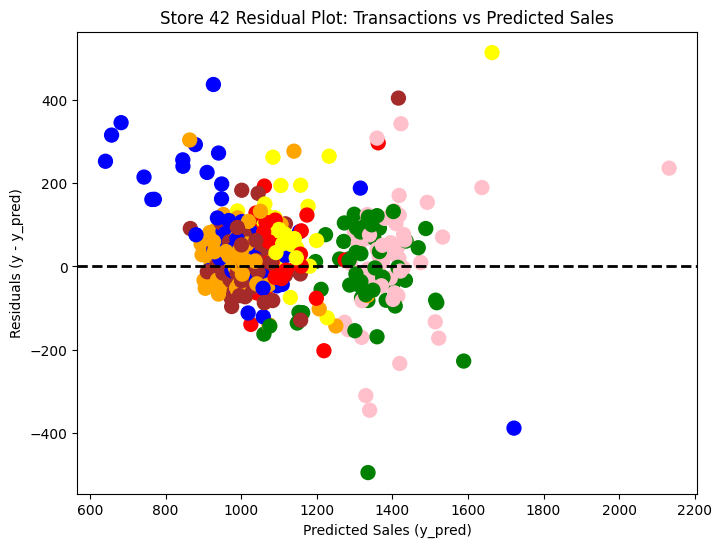

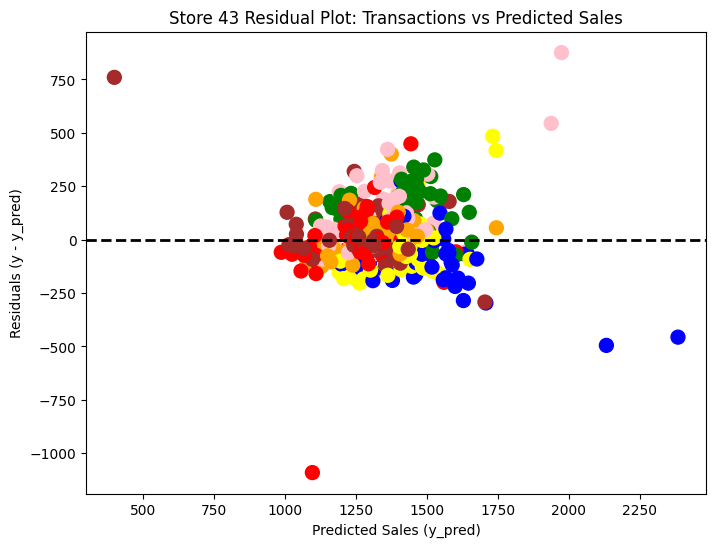

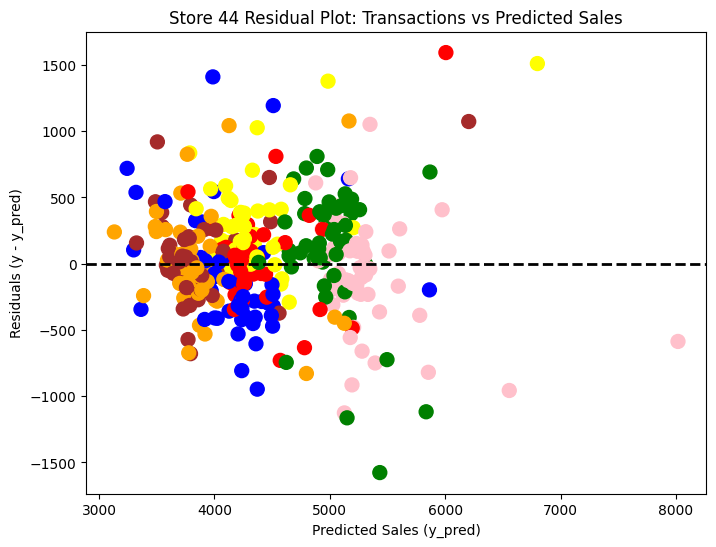

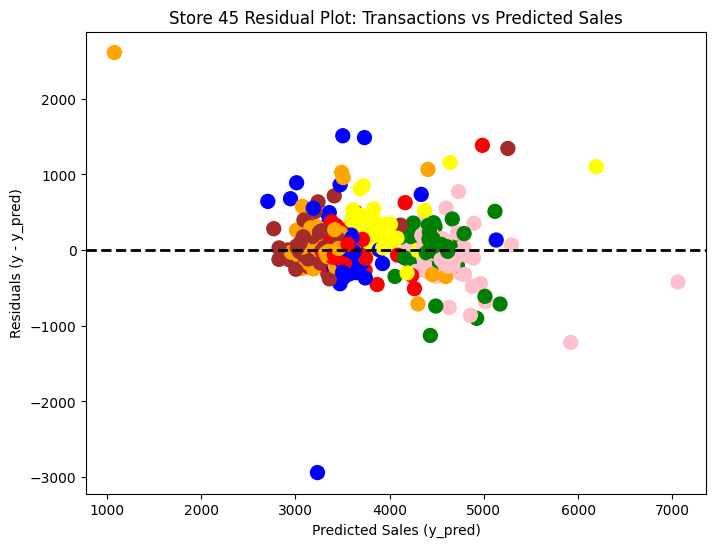

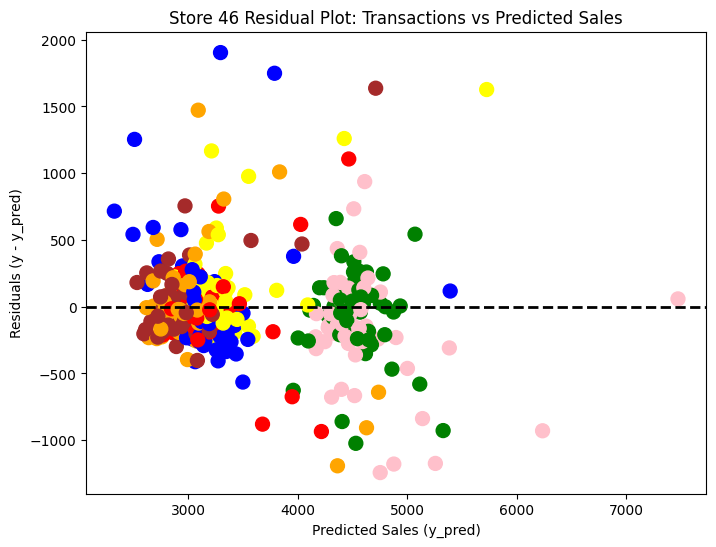

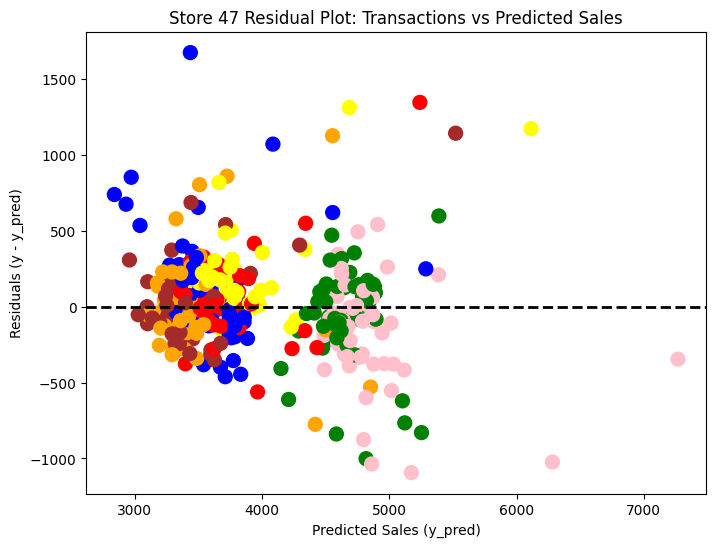

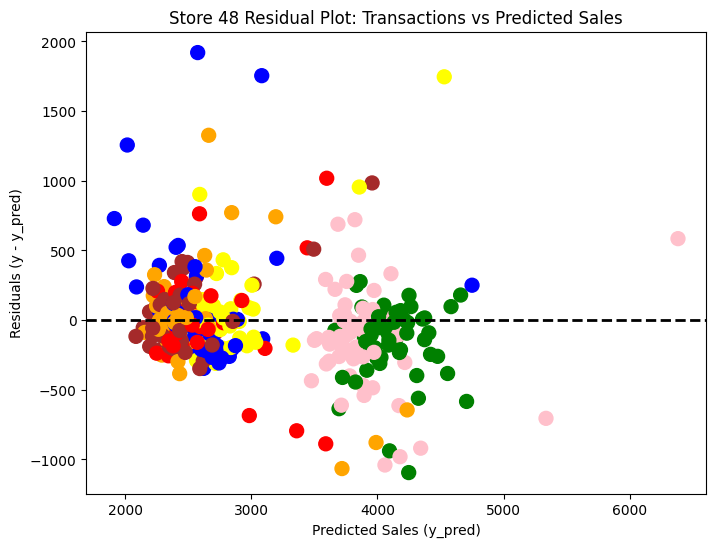

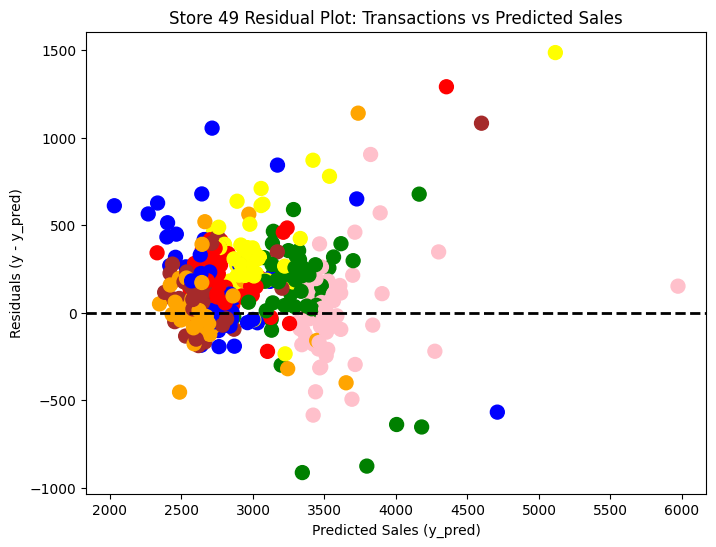

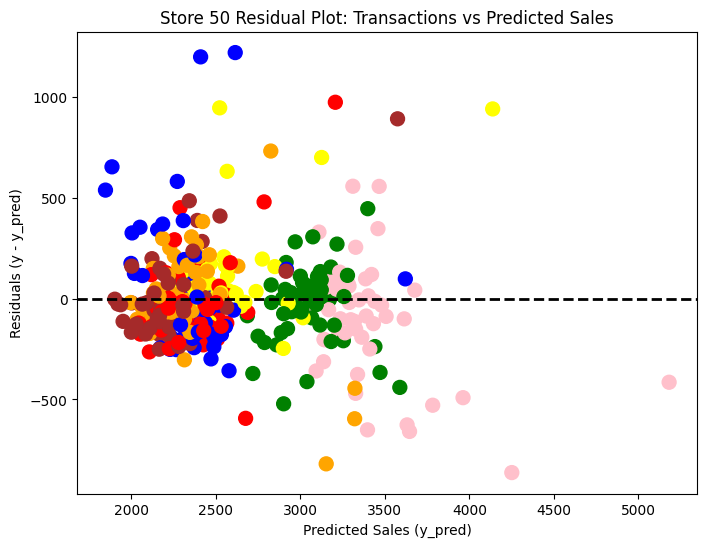

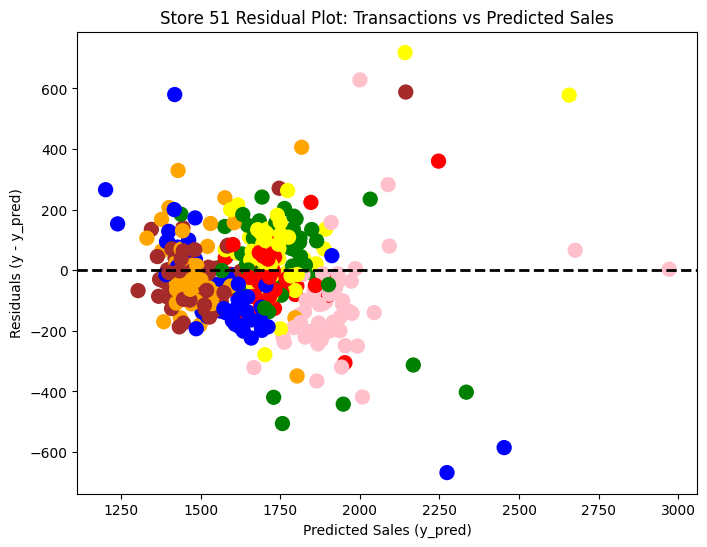

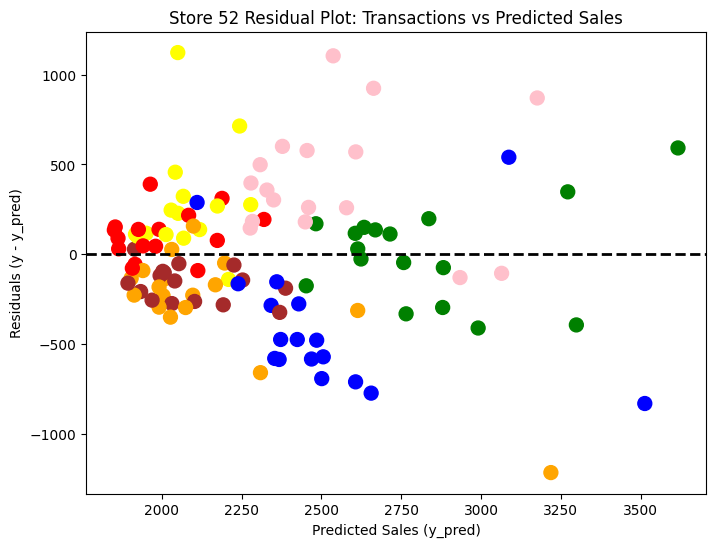

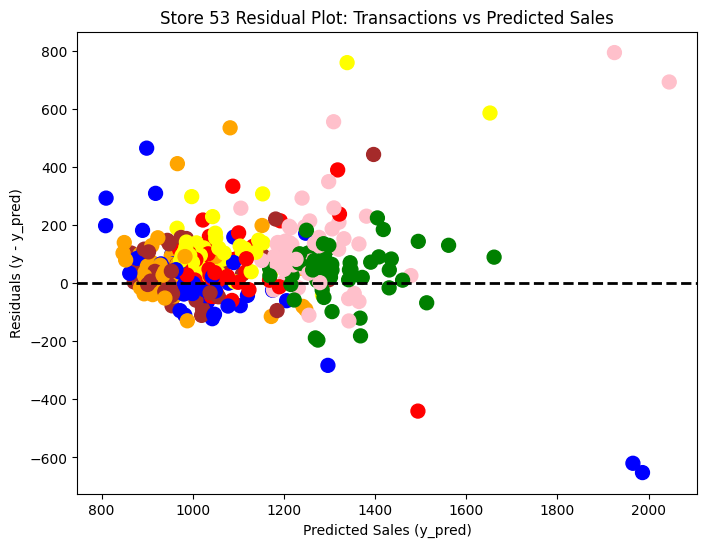

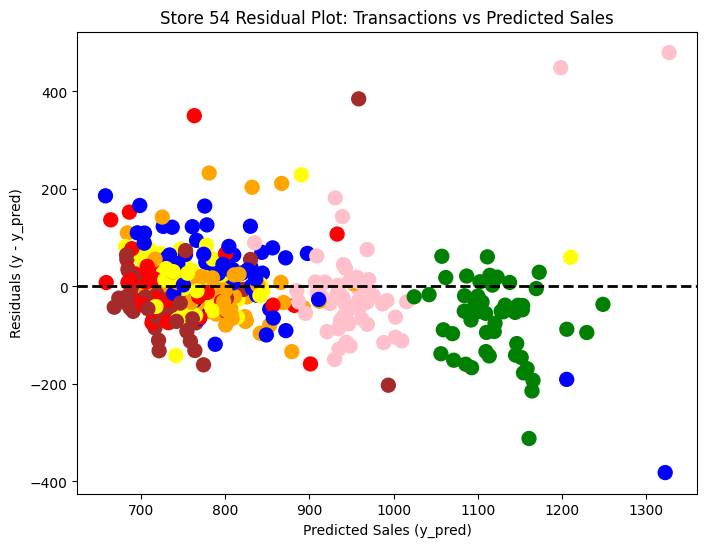

In [343]:
nbr = list(set(resid["store_nbr"]))
# Iterate over each store number and plot residuals
for i in nbr:
    # Filter the DataFrame for the current store number
    df_filter = resid.loc[resid["store_nbr"] == i]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with two colors based on 'day_cat' (day of the week)
    plt.scatter(df_filter['y_pred'], df_filter['residuals'], 
                c=df_filter['day_cat'].map({'Sunday': 'green', 'Monday': 'blue', 
                                            'Tuesday': 'orange', 'Wednesday': 'red', 
                                            'Thursday': 'brown', 'Friday': 'yellow', 
                                            'Saturday': 'pink'}), s=100)
    
    # Add a horizontal line at 0 (for residuals)
    plt.axhline(0, color='black', lw=2, linestyle='--')
    
    # Add labels and title
    plt.title(f'Store {i} Residual Plot: Transactions vs Predicted Sales')
    plt.xlabel('Predicted Sales (y_pred)')
    plt.ylabel('Residuals (y - y_pred)')
    
    # Show the plot
    plt.show()

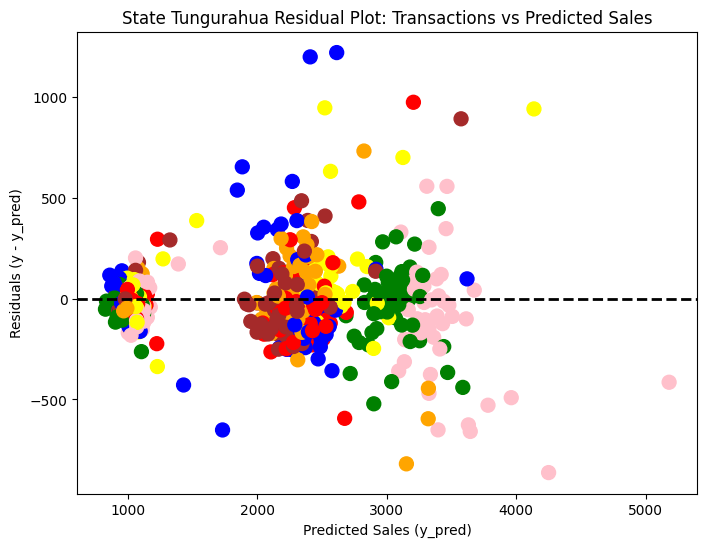

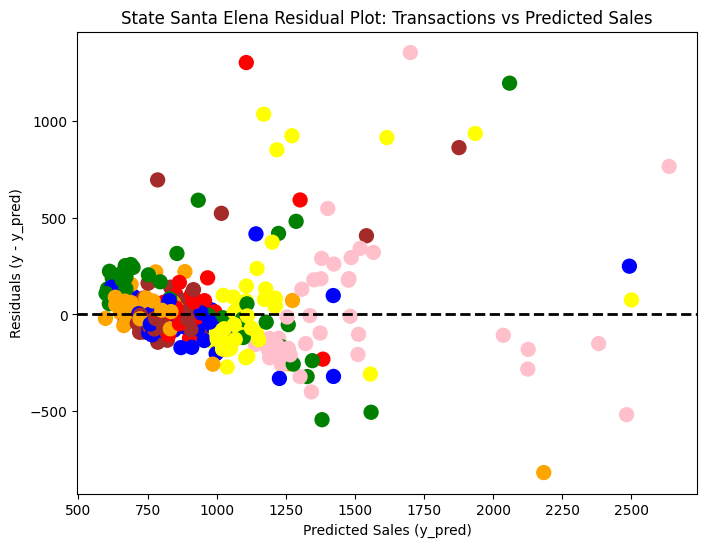

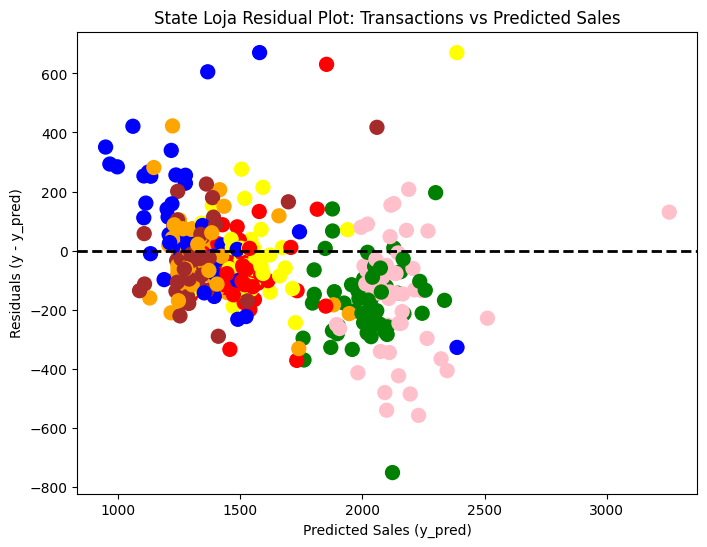

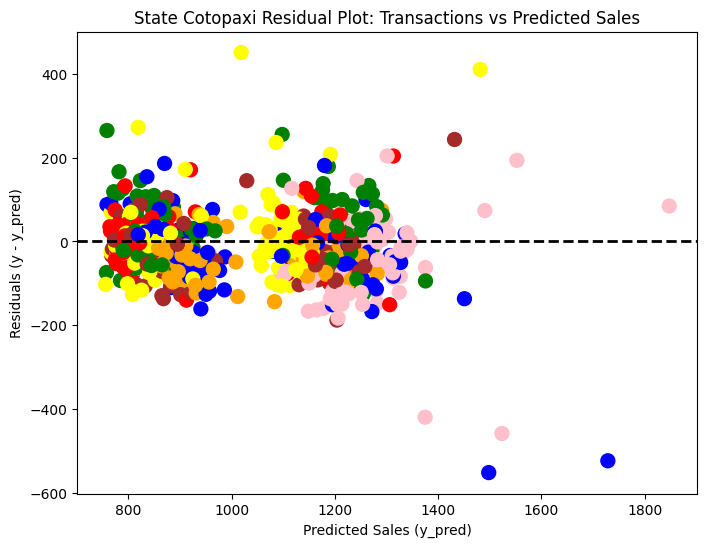

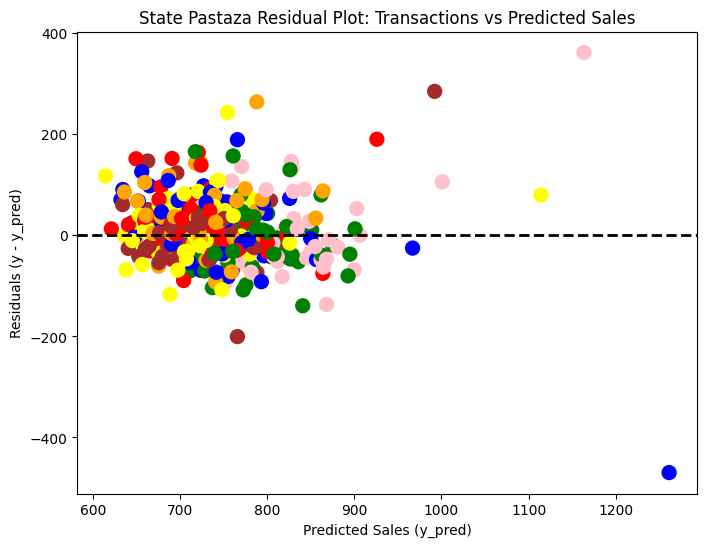

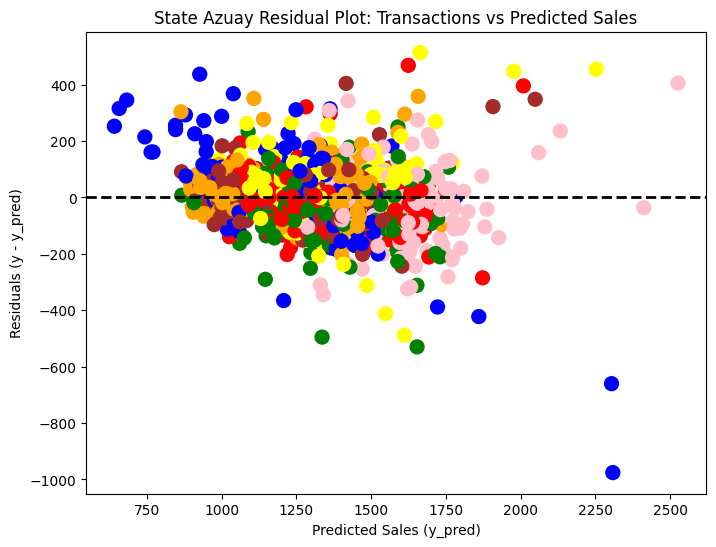

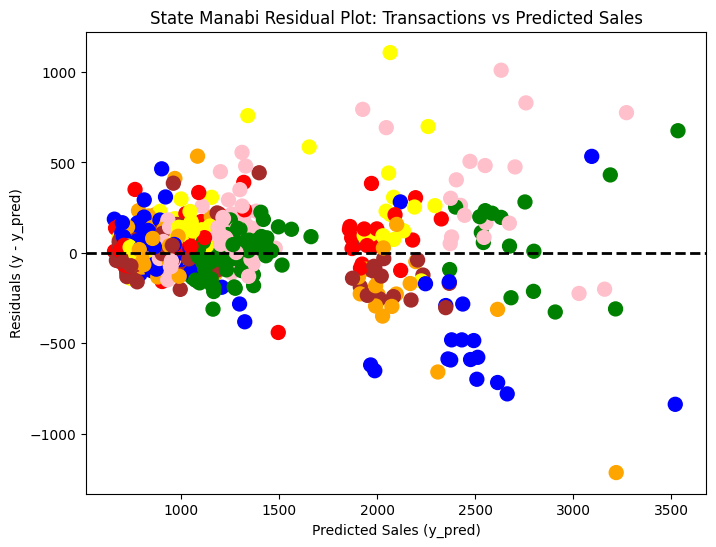

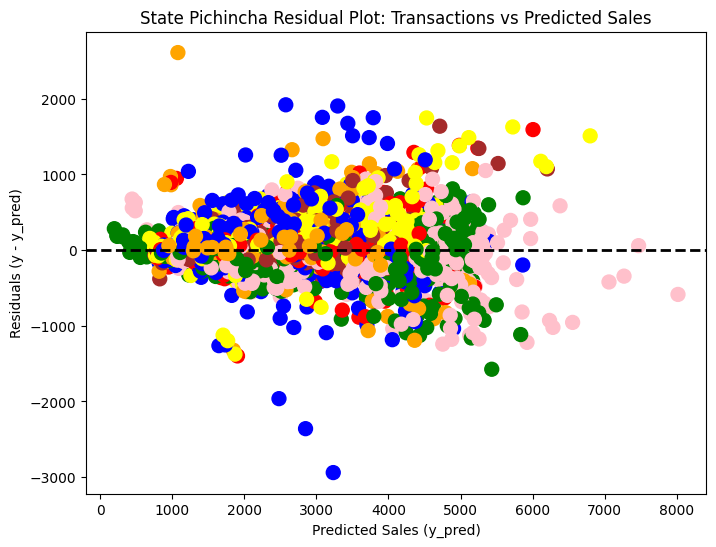

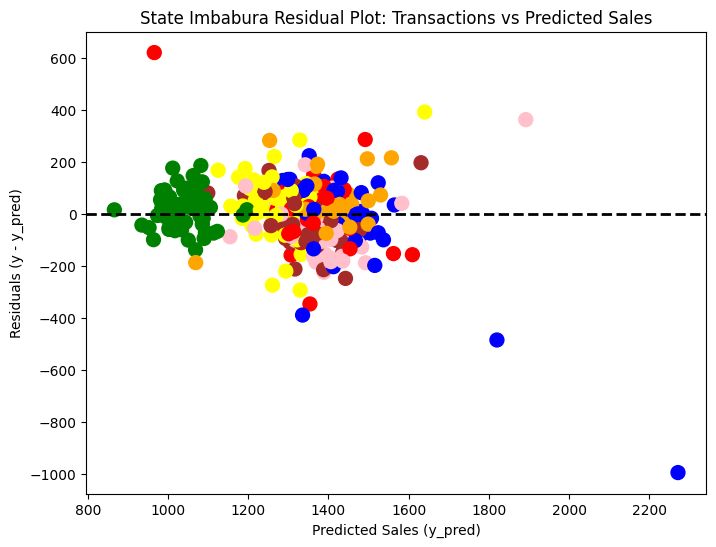

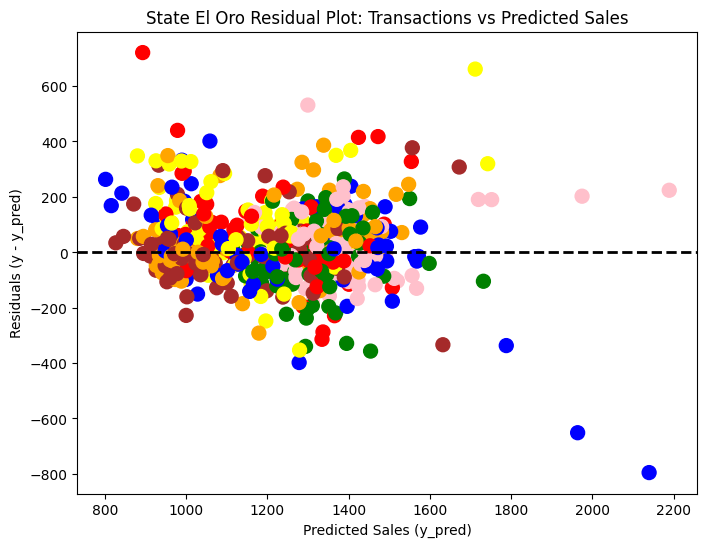

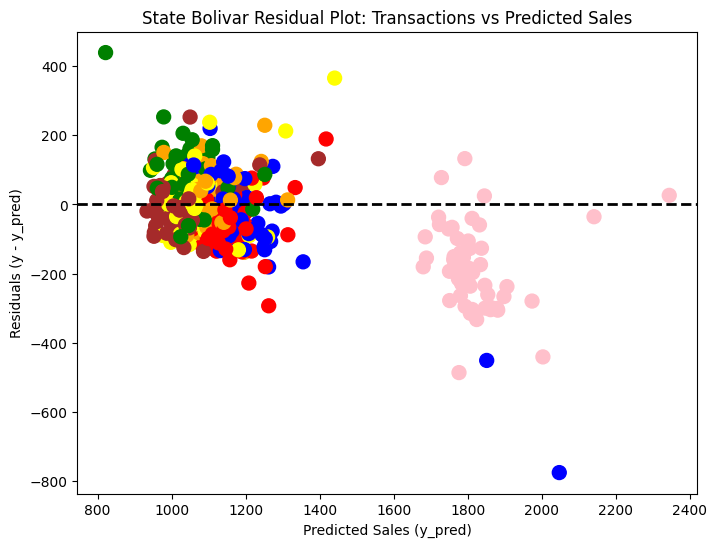

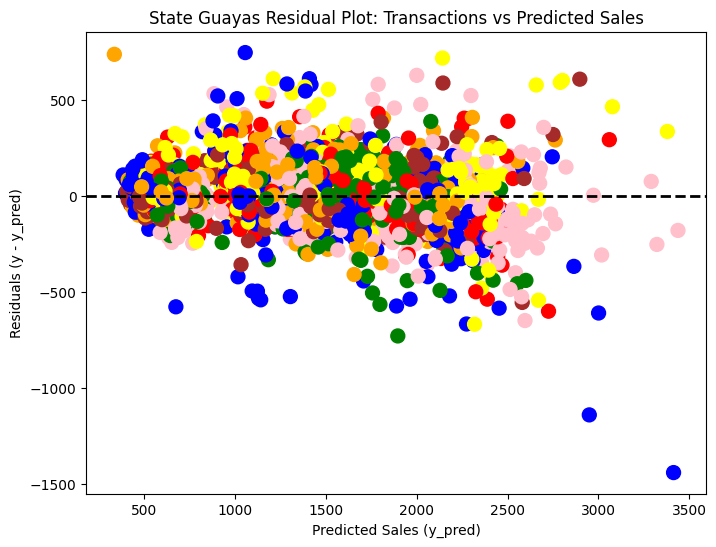

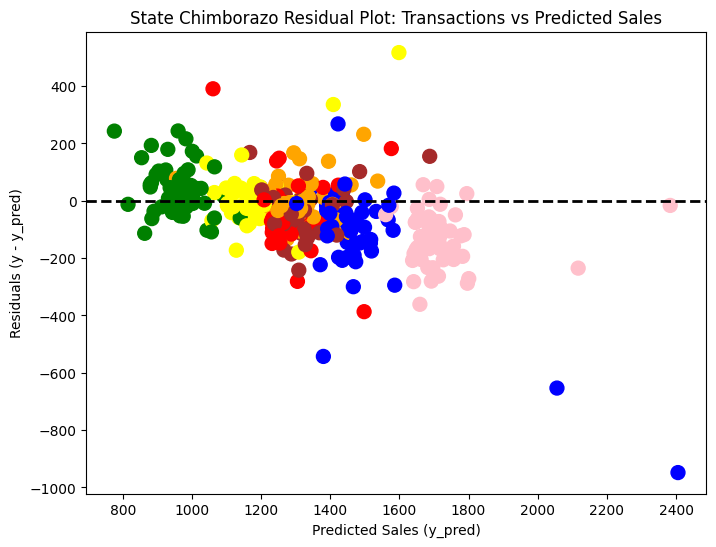

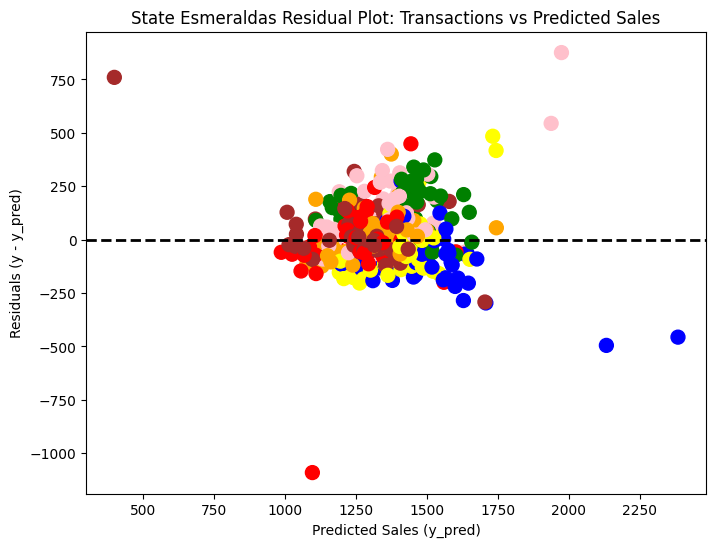

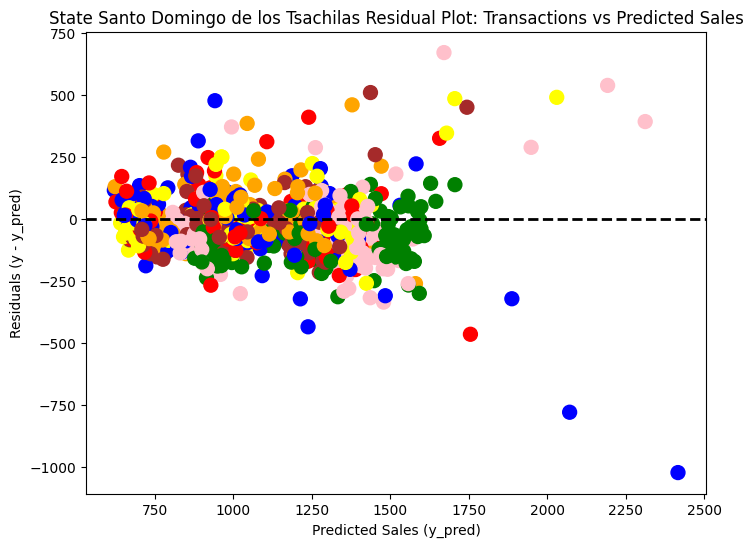

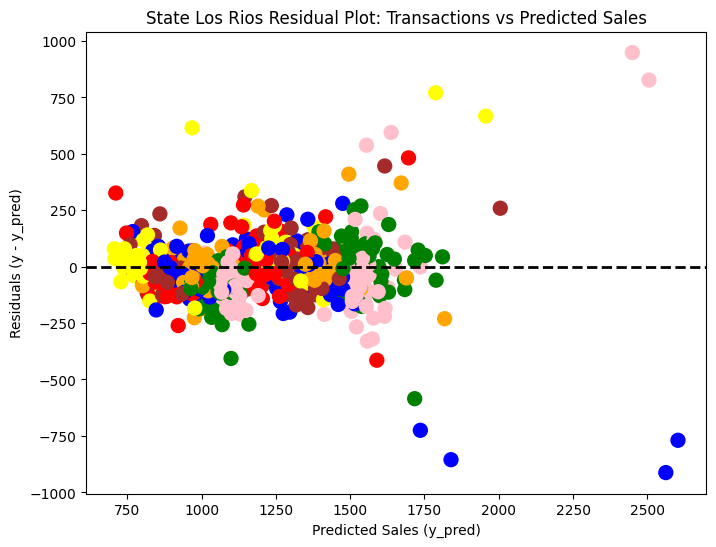

In [337]:
state = list(set(resid["state"]))
# Iterate over each store number and plot residuals
for i in state:
    # Filter the DataFrame for the current store number
    df_filter = resid.loc[resid["state"] == i]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with two colors based on 'day_cat' (day of the week)
    plt.scatter(df_filter['y_pred'], df_filter['residuals'], 
                c=df_filter['day_cat'].map({'Sunday': 'green', 'Monday': 'blue', 
                                            'Tuesday': 'orange', 'Wednesday': 'red', 
                                            'Thursday': 'brown', 'Friday': 'yellow', 
                                            'Saturday': 'pink'}), s=100)
    
    # Add a horizontal line at 0 (for residuals)
    plt.axhline(0, color='black', lw=2, linestyle='--')
    
    # Add labels and title
    plt.title(f'State {i} Residual Plot: Transactions vs Predicted Sales')
    plt.xlabel('Predicted Sales (y_pred)')
    plt.ylabel('Residuals (y - y_pred)')
    
    # Show the plot
    plt.show()

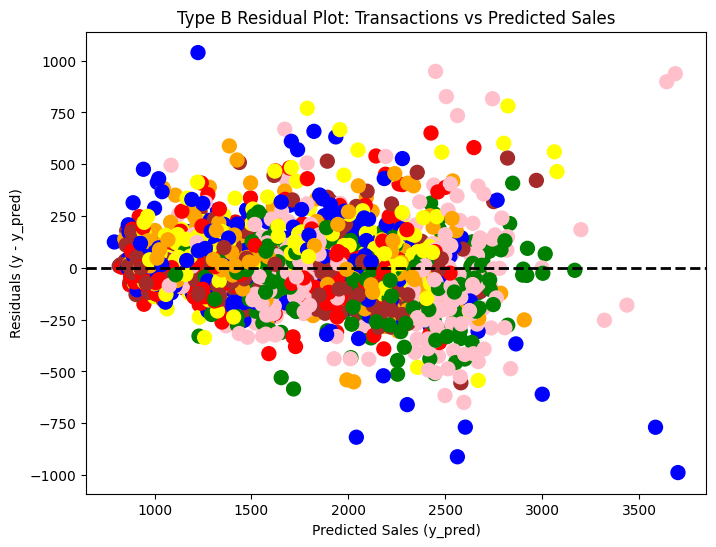

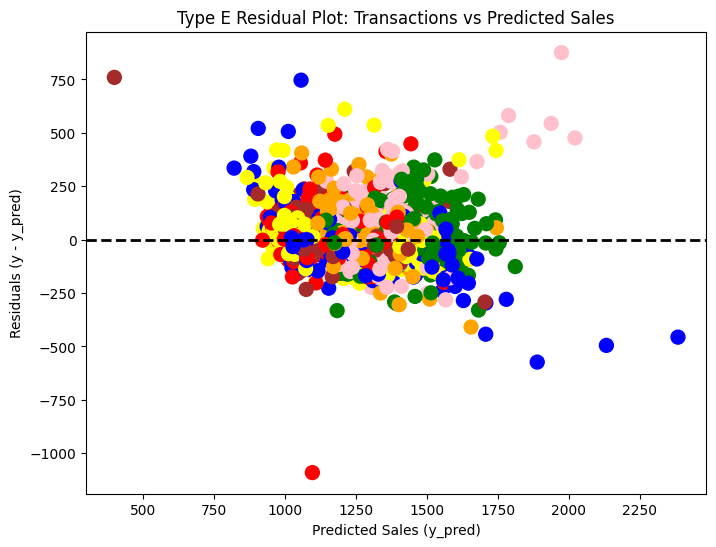

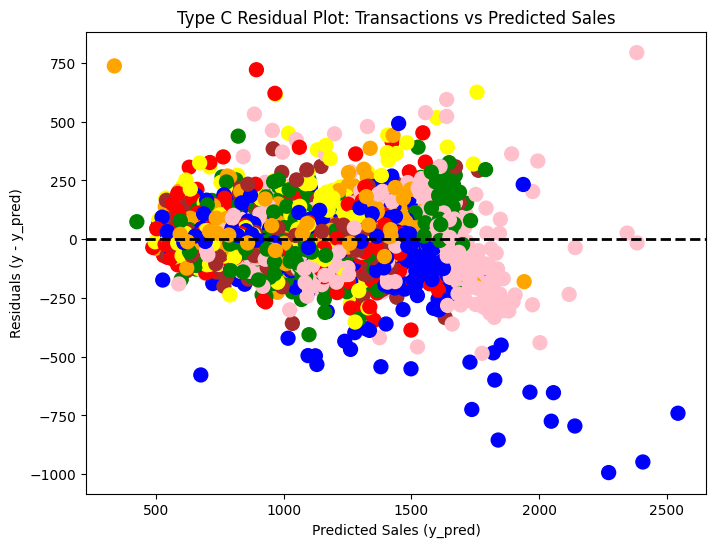

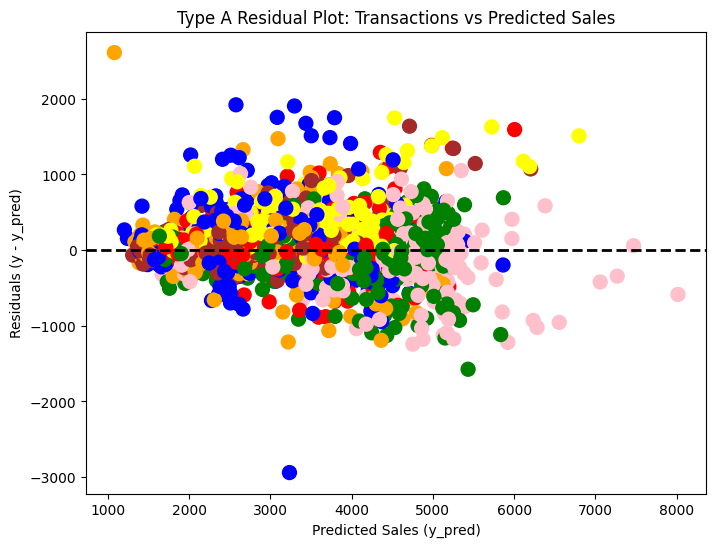

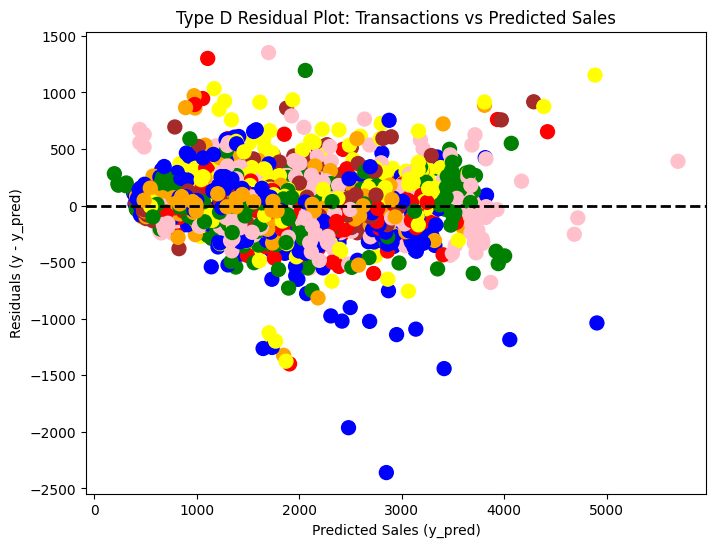

In [338]:
_type = list(set(resid["type"]))
# Iterate over each store number and plot residuals
for i in _type:
    # Filter the DataFrame for the current store number
    df_filter = resid.loc[resid["type"] == i]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with two colors based on 'day_cat' (day of the week)
    plt.scatter(df_filter['y_pred'], df_filter['residuals'], 
                c=df_filter['day_cat'].map({'Sunday': 'green', 'Monday': 'blue', 
                                            'Tuesday': 'orange', 'Wednesday': 'red', 
                                            'Thursday': 'brown', 'Friday': 'yellow', 
                                            'Saturday': 'pink'}), s=100)
    
    # Add a horizontal line at 0 (for residuals)
    plt.axhline(0, color='black', lw=2, linestyle='--')
    
    # Add labels and title
    plt.title(f'Type {i} Residual Plot: Transactions vs Predicted Sales')
    plt.xlabel('Predicted Sales (y_pred)')
    plt.ylabel('Residuals (y - y_pred)')
    
    # Show the plot
    plt.show()

In [331]:
resid.to_csv('resid.csv')